<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-3/blob/main/Inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carga de los datasets

In [1]:
!wget https://www.dropbox.com/s/mvhvpxm1n2k02rv/stitching.zip?dl=1 -O stitching.zip

--2021-04-27 17:00:53--  https://www.dropbox.com/s/mvhvpxm1n2k02rv/stitching.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/mvhvpxm1n2k02rv/stitching.zip [following]
--2021-04-27 17:00:53--  https://www.dropbox.com/s/dl/mvhvpxm1n2k02rv/stitching.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc665613d6d5822256c94fb83b6c.dl.dropboxusercontent.com/cd/0/get/BNYn0tExeUy2g8R4y_eKTT7Km5ogzwdBY1xY5X-b5f2oLIhpGMn_fselYNNbtvqZz3txiLvbAGyFK3Yvis3zsbgZrEo20knLD4w-AkNQ_99CDjjc1V2S2OQEE4QeHVDrUTfNTWTU80Z3B6B2fzTXVJn0/file?dl=1# [following]
--2021-04-27 17:00:54--  https://uc665613d6d5822256c94fb83b6c.dl.dropboxusercontent.com/cd/0/get/BNYn0tExeUy2g8R4y_eKTT7Km5ogzwdBY1xY5X-b5f2oLIhpGMn_fselYNNbtvqZz3txiLvbAGyFK3Yvis

In [2]:
!unzip stitching.zip

Archive:  stitching.zip
   creating: Abalos/
  inflating: Abalos/Abalos_04.jpg    
  inflating: Abalos/Abalos_05.jpg    
  inflating: Abalos/Abalos_06.jpg    
  inflating: Abalos/Abalos_07.jpg    
  inflating: Abalos/Abalos_01.jpg    
  inflating: Abalos/Abalos_02.jpg    
  inflating: Abalos/Abalos_03.jpg    
   creating: Brieva/
  inflating: Brieva/Brieva-13.jpg    
  inflating: Brieva/Brieva-14.jpg    
  inflating: Brieva/Brieva-16.jpg    
  inflating: Brieva/Brieva-23.jpg    
  inflating: Brieva/Brieva-25.jpg    
  inflating: Brieva/Brieva-27.jpg    
  inflating: Brieva/Brieva-28 A.jpg  
  inflating: Brieva/Brieva-28 B.jpg  
  inflating: Brieva/Brieva-28 C.jpg  
  inflating: Brieva/Brieva-29.jpg    
  inflating: Brieva/Brieva-30.jpg    
  inflating: Brieva/Brieva-32.jpg    
  inflating: Brieva/Brieva-34 bis.jpg  
  inflating: Brieva/Brieva-34.jpg    
  inflating: Brieva/Brieva-35 A.jpg  
  inflating: Brieva/Brieva-35 B.jpg  
  inflating: Brieva/Brieva-35 C.jpg  
  inflating: Brieva/

In [ ]:
!pip install imutils
import numpy as np
import imutils
import cv2

In [17]:
class Stitcher:
    def __init__(self):
        # determine if we are using OpenCV v3.X
        self.isv3 = imutils.is_cv3(or_better=True)
    def stitch(self, images, ratio=0.75, reprojThresh=4.0,showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None
        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)
        # return the stitched image
        return result         
    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # check to see if we are using OpenCV 3.X
        if self.isv3:
            # detect and extract features from the image
            descriptor = cv2.ORB_create(nfeatures=1500)
            #.SIFT_create()
            (kps, features) = descriptor.detectAndCompute(image, None)
        # otherwise, we are using OpenCV 2.4.X
        else:
            # detect keypoints in the image
            detector = cv2.FeatureDetector_create("ORB")
            kps = detector.detect(gray)
            # extract features from the image
            extractor = cv2.DescriptorExtractor_create("ORB")
            (kps, features) = extractor.compute(gray, kps)
        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])
        # return a tuple of keypoints and features
        return (kps, features)   
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []
        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx)) 
        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])
            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
              reprojThresh)
            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)
        # otherwise, no homograpy could be computed
        return None 
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
      # initialize the output visualization image
      (hA, wA) = imageA.shape[:2]
      (hB, wB) = imageB.shape[:2]
      vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
      vis[0:hA, 0:wA] = imageA
      vis[0:hB, wA:] = imageB
      # loop over the matches
      for ((trainIdx, queryIdx), s) in zip(matches, status):
          # only process the match if the keypoint was successfully
          # matched
          if s == 1:
              # draw the match
              ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
              ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
              cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
      # return the visualization
      return vis


In [5]:
import matplotlib.pyplot as plt

def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

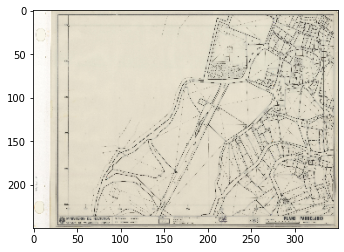

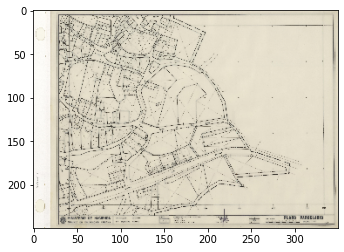

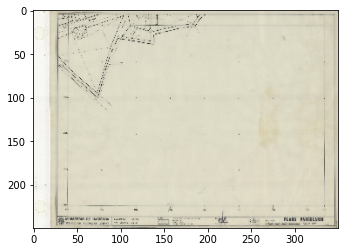

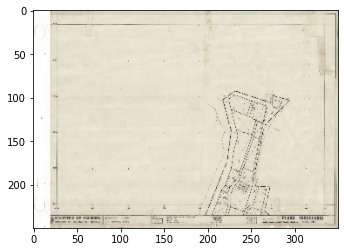

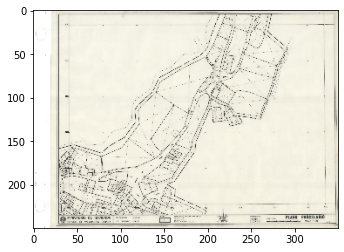

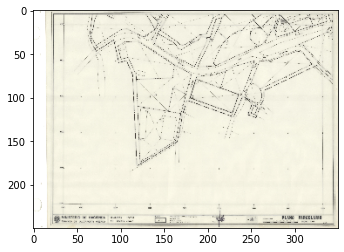

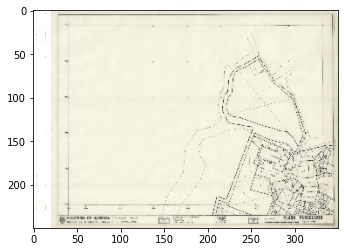

In [29]:
#CUIDADO: POSIBLE MUERTE por culpa del fichero Thumbs

import os
# Cargando imágenes de Abalos
abalos = []
for image in os.listdir("Abalos"):
    i=cv2.imread("Abalos/" + image)

    i = cv2.resize(i, (350,250))
    mostrarImagen(i)

    abalos.append(i)

# # Cargando imágenes de Brieva
# brieva = []
# for image in os.listdir("Brieva"):
#     brieva.append(cv2.imread("Brieva/" + image))

# # Cargando imágenes de Préjano
# prejano = []
# for image in os.listdir("Préjano"):
#     prejano.append(cv2.imread("Préjano/" + image))

# # Cargando imágenes de Uruñuela
# urunuela = []
# for image in os.listdir("Uruñuela"):
#     urunuela.append(cv2.imread("Uruñuela/" + image))

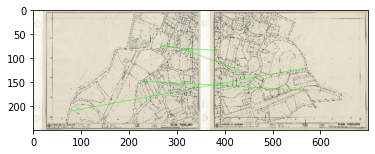

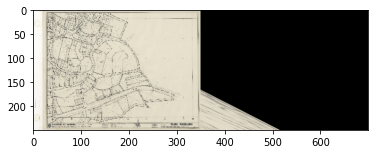

-1

In [31]:
# import the necessary packages
#from pyimagesearch.panorama import Stitcher
import argparse
import imutils
import cv2
# construct the argument parse and parse the arguments
##ap = argparse.ArgumentParser()
##ap.add_argument("-f", "--first", required=True,help="path to the first image")
##ap.add_argument("-s", "--second", required=True,help="path to the second image")
##args = vars(ap.parse_args())
# load the two images and resize them to have a width of 400 pixels
# (for faster processing)
##imageA = cv2.imread(args["first"])
##imageB = cv2.imread(args["second"])
##imageA = imutils.resize(imageA, width=400)
##imageB = imutils.resize(imageB, width=400)

# stitch the images together to create a panorama
stitcher = Stitcher()
(result, vis) = stitcher.stitch([abalos[1],abalos[0]], showMatches=True)
# show the images
mostrarImagen(vis)
mostrarImagen(result)
cv2.waitKey(0)

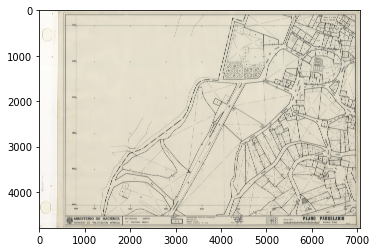

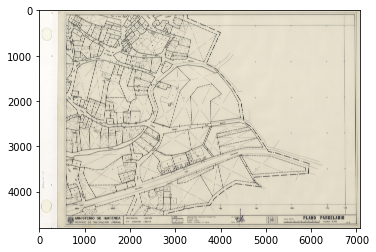

In [19]:
mostrarImagen(abalos[0])
mostrarImagen(abalos[1])